# Pandas Cheat Sheet

# Table of contents


- **The setup**: anaconda, Python, pandas, Jupyter
- **Importing data**: from csv (and options), from the web, creating from scratch, convering types, rename cols
- **Summarizing data**: len(df), shape, value_counts, head, tail, max(), min(), mean, dtype, info(), describe(), memory_usage(), scatter matrix, corr, isnull, notnull, unique(), nlargest
- **Selecting and computing**: select subset of row and cols, .loc, .iloc, drop columns, assign, apply/map/applymap, multiindex
- **Filtering and sorting**: >=, AND, OR, ==, ~, str.contains, str.startswith, sort_values, sort_index, filtering on sorted/unsorted, isin()
- **Split-apply-combine and pivots**: groupby, dt.month, dt.year, groupby.mean(), agg, stack, unstack, pivot, melt, merge
- **Time series manipulations**: downsampling, upsampling, rolling, mean, simple plotting
- **Plotting**: built-in plotting, advanced plotting, matplotlib, seaborn, styles, saving
- **Modeling and machine learning**: .value, feeding data, saving data
- **Misc tips and tricks**: pandas options, vectorization, timings with %%timeit, profiling with lprun

**principles:** small examples, no more than 5 rows. one or two data sets, no more.

# The setup

## Python and Anaconda

If you haven't done it, start by installing Python.
The [Anaconda Distribution](https://www.anaconda.com/download/) is great, install version `3.X`.
- If you're on Windows, you will get a program called *Anaconda Prompt*. Open in at run `conda --version` to verify that everything works.
- If you're on Linux, open a terminal and run `conda --version`.

## Pandas, NumPy and matplotlib

To install packages, run `conda install <package>`. The Anaconda distribution comes with the three packages we will require, namely [pandas](https://pandas.pydata.org/), [NumPy](http://www.numpy.org/) and [matplotlib](https://matplotlib.org/).

- **NumPy** implements $n$-dimensional arrays in Python for efficient computations. See the [arXiv](https://arxiv.org/pdf/1102.1523.pdf) paper for a nice introduction. To learn basic NumPy, consider doing these [100 NumPy exercises](https://github.com/rougier/numpy-100).
- **Matplotlib** is the most popular library for plotting in Python. See the beautiful [gallery](https://matplotlib.org/gallery.html) to get an overview of the capabilities of matplotlib.
- **Pandas** is a library for data analysis based on two objects, the [Series](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.Series.html) and the [DataFrame](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.html).

## Jupyter

The [Jupyter Notebook](https://jupyter-notebook.readthedocs.io/en/stable/) is an environment in which you can run Python code, display graphs and work with data interactively. Think of it as a tool between the simple terminal and the full fledged IDE. Move to a directory using the `cd` command in the terminal, then run `jupyter notebook` to start up a notebook. 

## Importing packages

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
%matplotlib inline

To make this Jupyter Notebook reproducible, here are the versions of the libraries we will be using.

In [2]:
for lib in [pd, np, matplotlib]:
    print(f'{lib.__name__.ljust(12)} version {lib.__version__}')

pandas       version 0.22.0
numpy        version 1.14.2
matplotlib   version 2.2.2


# Importing data

Using `!` let's us use terminal commands. The `head` command shows the first rows of the file.

In [3]:
!head data/movie_metadata.csv -n 2

color,director_name,num_critic_for_reviews,duration,director_facebook_likes,actor_3_facebook_likes,actor_2_name,actor_1_facebook_likes,gross,genres,actor_1_name,movie_title,num_voted_users,cast_total_facebook_likes,actor_3_name,facenumber_in_poster,plot_keywords,movie_imdb_link,num_user_for_reviews,language,country,content_rating,budget,title_year,actor_2_facebook_likes,imdb_score,aspect_ratio,movie_facebook_likes
Color,James Cameron,723,178,0,855,Joel David Moore,1000,760505847,Action|Adventure|Fantasy|Sci-Fi,CCH Pounder,Avatar ,886204,4834,Wes Studi,0,avatar|future|marine|native|paraplegic,http://www.imdb.com/title/tt0499549/?ref_=fn_tt_tt_1,3054,English,USA,PG-13,237000000,2009,936,7.9,1.78,33000


It's a huge file, so we'll only load a couple of columns into a pandas DataFrame.
To familiarize ourselves with with [magic commands](http://ipython.readthedocs.io/en/stable/interactive/magics.html), we'll use `%%time` to time the execution of the cell below.

In [4]:
%%time

cols_to_use = ['movie_title', 'director_name', 'country', 'content_rating', 'imdb_score', 'gross']
df = pd.read_csv(r'data/movie_metadata.csv', sep=',', usecols=cols_to_use)
print(f'Loaded data of size {df.shape} into memory.')

Loaded data of size (5043, 6) into memory.
CPU times: user 44 ms, sys: 525 µs, total: 44.5 ms
Wall time: 42.9 ms


The df.shape gives the rows and columns of the DataFrame. 
This leads us naturally to consider summarizations.

# Summarizing data

There are three methods that are useful to peek at the data, they are df.head, df.tail and df.sample.
Head and tail are $\mathcal{O}(1)$ operations, while sample is $\mathcal{O}(n)$, where $n$ is the number of rows.
For small datasets, this makes no difference in practice. We'll use df.sample here.

In [5]:
df.sample(n=2, replace=False, weights=None, random_state=None)

,director_name,gross,movie_title,country,content_rating,imdb_score
3097,Darren Lynn Bousman,63270259.0,Saw IV,USA,R,5.9
1999,Roman Polanski,NaN,Carnage,France,R,7.2


We should make sure the data types are correct. To do so, we can use df.dtypes, or df.info() for some more information.

In [6]:
df.info(verbose=True, memory_usage=True, null_counts=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5043 entries, 0 to 5042
Data columns (total 6 columns):
director_name     4939 non-null object
gross             4159 non-null float64
movie_title       5043 non-null object
country           5038 non-null object
content_rating    4740 non-null object
imdb_score        5043 non-null float64
dtypes: float64(2), object(4)
memory usage: 236.5+ KB


We have some null values. Let's count them by chaining df.isnull() and df.sum().

In [7]:
null_values = df.isnull().sum()
null_values

director_name     104
gross             884
movie_title         0
country             5
content_rating    303
imdb_score          0
dtype: int64

The result of the above is not a DataFrame, but a Series.

In [8]:
type(null_values)

pandas.core.series.Series

We can make the output prettier by converting null_values to a DataFrame using to_frame(), then transposing using .T, and finally renaming the first index.

In [9]:
null_values.to_frame().T.rename(index={0:'Missing values'})

,director_name,gross,movie_title,country,content_rating,imdb_score
Missing values,104,884,0,5,303,0


The above is called method chaining, and can be written like so:

In [10]:
(df
    .isnull()    # Figure out whether every entry is null (missing), or not
    .sum(axis=0) # Sum over each column, axis=0 is the default
    .to_frame()  # The result is a Series, convert to DataFrame
    .T           # Transpose (switch rows and columns)
    .rename(index={0:'Missing values'}) # Rename the index and show it
)

,director_name,gross,movie_title,country,content_rating,imdb_score
Missing values,104,884,0,5,303,0


A tour of summarization would not be completed without df.describe().
Calling df.count(), df.nunique(), df.mean(), df.std(), df.min(), df.quantile(), df.max() is also possible.

In [11]:
df.describe(percentiles=[0.5], include='all').fillna('')

,director_name,gross,movie_title,country,content_rating,imdb_score
count,4939,4159,5043,5038,4740,5043
unique,2398,,4917,65,18,
top,Steven Spielberg,,King Kong,USA,R,
freq,26,,3,3807,2118,
mean,,4.84684e+07,,,,6.44214
std,,6.8453e+07,,,,1.12512
min,,162,,,,1.6
50%,,2.55175e+07,,,,6.6
max,,7.60506e+08,,,,9.5


## Visualizations

In [12]:
df.corr(method='spearman', min_periods=1)

,gross,imdb_score
gross,1.000000,0.096247
imdb_score,0.096247,1.000000


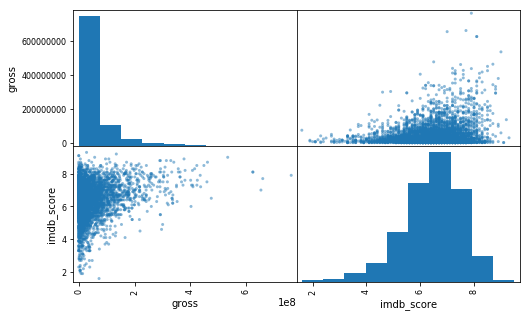

In [13]:
plot = pd.plotting.scatter_matrix(df, alpha=0.5, figsize=(8,5))

Honorable mentions are len(df).

In [14]:
# len(df), shape, value_counts, head, tail, max(), min(), mean, dtype, info(), 
# describe(), memory_usage(), scatter matrix, corr, isnull, notnull, unique(), nlargest

# Selecting and computing

In [15]:
# - **Selecting and computing**: select subset of row and cols, .loc, .iloc, 
# drop columns, assign, apply/map/applymap, multiindex

In [16]:
columns = ['movie_title', 'director_name', 'country', 'content_rating', 'imdb_score']
df[columns].head(3)

,movie_title,director_name,country,content_rating,imdb_score
0,Avatar,James Cameron,USA,PG-13,7.9
1,Pirates of the Caribbean: At World's End,Gore Verbinski,USA,PG-13,7.1
2,Spectre,Sam Mendes,UK,PG-13,6.8


In [17]:
df.loc[100:102, columns]

,movie_title,director_name,country,content_rating,imdb_score
100,The Fast and the Furious,Rob Cohen,USA,PG-13,6.7
101,The Curious Case of Benjamin Button,David Fincher,USA,PG-13,7.8
102,X-Men: First Class,Matthew Vaughn,USA,PG-13,7.8


In [18]:
df_cols = df.loc[:, columns + ['director_facebook_likes', 'gross']]
df_cols.head(2)

/home/tommy/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  """Entry point for launching an IPython kernel.
/home/tommy/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:1367: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  return self._getitem_tuple(key)


,movie_title,director_name,country,content_rating,imdb_score,director_facebook_likes,gross
0,Avatar,James Cameron,USA,PG-13,7.9,NaN,760505847.0
1,Pirates of the Caribbean: At World's End,Gore Verbinski,USA,PG-13,7.1,NaN,309404152.0


In [19]:
df_cols = df_cols.drop(columns=['director_facebook_likes'])
df_cols.head(2)

,movie_title,director_name,country,content_rating,imdb_score,gross
0,Avatar,James Cameron,USA,PG-13,7.9,760505847.0
1,Pirates of the Caribbean: At World's End,Gore Verbinski,USA,PG-13,7.1,309404152.0


In [20]:
df_cols.nlargest(3, columns=['imdb_score'], keep='first')

,movie_title,director_name,country,content_rating,imdb_score,gross
2765,Towering Inferno,John Blanchard,Canada,NaN,9.5,NaN
1937,The Shawshank Redemption,Frank Darabont,USA,R,9.3,28341469.0
3466,The Godfather,Francis Ford Coppola,USA,R,9.2,134821952.0


In [21]:
df_cols = df_cols.assign(gross_log = lambda df: np.log(df.gross))

In [22]:
df_cols.describe(percentiles=[0.5]).applymap(lambda x: '{:,}'.format(round(x)))

,imdb_score,gross,gross_log
count,"5,043","4,159","4,159"
mean,6,"48,468,408",16
std,1,"68,452,990",2
min,2,162,5
50%,7,"25,517,500",17
max,10,"760,505,847",20


In [23]:
df_cols.corr()

,imdb_score,gross,gross_log
imdb_score,1.000000,0.198021,0.074280
gross,0.198021,1.000000,0.616034
gross_log,0.074280,0.616034,1.000000


# Filtering and sorting

In [24]:
df_cols[df_cols.country != 'USA'].head(3)

,movie_title,director_name,country,content_rating,imdb_score,gross,gross_log
2,Spectre,Sam Mendes,UK,PG-13,6.8,200074175.0,19.114199
4,Star Wars: Episode VII - The Force Awakens ...,Doug Walker,NaN,NaN,7.1,NaN,NaN
9,Harry Potter and the Half-Blood Prince,David Yates,UK,PG,7.5,301956980.0,19.525795


In [25]:
mask = ((df_cols.imdb_score > 8) & (df_cols.country != 'USA') & (df_cols.gross > 10**6))
df_cols[mask].nlargest(3, columns=['imdb_score'])

,movie_title,director_name,country,content_rating,imdb_score,gross,gross_log
4498,"The Good, the Bad and the Ugly",Sergio Leone,Italy,Approved,8.9,6100000.0,15.623799
270,The Lord of the Rings: The Fellowship of the R...,Peter Jackson,New Zealand,PG-13,8.8,313837577.0,19.564386
4029,City of God,Fernando Meirelles,Brazil,R,8.7,7563397.0,15.838831


In [26]:
# >=, AND, OR, ==, ~, str.contains, 
# str.startswith, sort_values, sort_index, filtering on sorted/unsorted, isin()

In [27]:
df_cols[df_cols.movie_title.str.lower().str.contains("ring")].nlargest(5, columns=['imdb_score'])

,movie_title,director_name,country,content_rating,imdb_score,gross,gross_log
2765,Towering Inferno,John Blanchard,Canada,NaN,9.5,NaN,NaN
339,The Lord of the Rings: The Return of the King,Peter Jackson,USA,PG-13,8.9,377019252.0,19.747807
270,The Lord of the Rings: The Fellowship of the R...,Peter Jackson,New Zealand,PG-13,8.8,313837577.0,19.564386
340,The Lord of the Rings: The Two Towers,Peter Jackson,USA,PG-13,8.7,340478898.0,19.645864
1196,The Conjuring 2,James Wan,USA,R,7.8,102310175.0,18.443520


In [28]:
df.country.value_counts().head(5)

USA        3807
UK          448
France      154
Canada      126
Germany      97
Name: country, dtype: int64

In [29]:
df.country.value_counts().sort_index().head(5)

Afghanistan     1
Argentina       4
Aruba           1
Australia      55
Bahamas         1
Name: country, dtype: int64

# Split-apply-combine and pivots

- **Split-apply-combine and pivots**: groupby, dt.month, dt.year, groupby.mean(), agg, stack, unstack, pivot, melt, merge

## Directors with the most movies

In [30]:
(df_cols.groupby(df.director_name).nunique().movie_title.nlargest(5).to_frame())

,movie_title
director_name,
Steven Spielberg,26
Woody Allen,22
Clint Eastwood,20
Martin Scorsese,20
Ridley Scott,16


In [31]:
(df_cols.groupby(df.director_name).mean().imdb_score.nlargest(5).to_frame())

,imdb_score
director_name,
John Blanchard,9.5
Cary Bell,8.7
Mitchell Altieri,8.7
Sadyk Sher-Niyaz,8.7
Charles Chaplin,8.6


In [32]:
df_cols.head()

,movie_title,director_name,country,content_rating,imdb_score,gross,gross_log
0,Avatar,James Cameron,USA,PG-13,7.9,760505847.0,20.449494
1,Pirates of the Caribbean: At World's End,Gore Verbinski,USA,PG-13,7.1,309404152.0,19.550159
2,Spectre,Sam Mendes,UK,PG-13,6.8,200074175.0,19.114199
3,The Dark Knight Rises,Christopher Nolan,USA,PG-13,8.5,448130642.0,19.920595
4,Star Wars: Episode VII - The Force Awakens ...,Doug Walker,NaN,NaN,7.1,NaN,NaN


In [33]:
director_stats = (df_cols.groupby(df.director_name).agg({'imdb_score':np.mean, 'gross_log':np.sum, 'movie_title':'nunique'}))

director_stats.head(3)

,imdb_score,gross_log,movie_title
director_name,,,
A. Raven Cruz,1.9,0.000000,1
Aaron Hann,6.0,0.000000,1
Aaron Schneider,7.1,16.032162,1


In [34]:
director_stats_norm = ((director_stats - director_stats.mean()) / director_stats.std())
director_stats_norm.head(3)

,imdb_score,gross_log,movie_title
director_name,,,
A. Raven Cruz,-3.885663,-0.737455,-0.488133
Aaron Hann,-0.213965,-0.737455,-0.488133
Aaron Schneider,0.771125,-0.321155,-0.488133


In [35]:
director_stats_norm.assign(score = lambda df: df.sum(axis = 1)).nlargest(3, 'score')

,imdb_score,gross_log,movie_title,score
director_name,,,,
Steven Spielberg,1.112117,11.419216,11.609254,24.140587
Woody Allen,0.689712,7.299573,9.673672,17.662958
Clint Eastwood,0.883067,8.041961,8.705881,17.630909


In [36]:
(df.loc[:, ('title_year', 'content_rating', 'movie_title')]
 .groupby(['title_year', 'content_rating']).nunique().movie_title).unstack(1).fillna(0).tail(5)

/home/tommy/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:858: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  return self._getitem_lowerdim(tup)


content_rating
title_year


## Pivot table

In [37]:
df.head(3)

,director_name,gross,movie_title,country,content_rating,imdb_score
0,James Cameron,760505847.0,Avatar,USA,PG-13,7.9
1,Gore Verbinski,309404152.0,Pirates of the Caribbean: At World's End,USA,PG-13,7.1
2,Sam Mendes,200074175.0,Spectre,UK,PG-13,6.8


In [38]:
(df
 .pivot_table(
     values='movie_title', 
     index='title_year', 
     columns='content_rating', 
     aggfunc=pd.DataFrame.nunique)
.fillna(0)
.tail(5))

KeyError: 'title_year'

values : column to aggregate, optional

index : column, Grouper, array, or list of the previous

    If an array is passed, it must be the same length as the data. The list can contain any of the other types (except list). Keys to group by on the pivot table index. If an array is passed, it is being used as the same manner as column values.

columns : column, Grouper, array, or list of the previous

    If an array is passed, it must be the same length as the data. The list can contain any of the other types (except list). Keys to group by on the pivot table column. If an array is passed, it is being used as the same manner as column values.

aggfunc : function or list of functions, default numpy.mean

    If list of functions passed, the resulting pivot table will have hierarchical columns whose top level are the function names (inferred from the function objects themselves)

fill_value : scalar, default None

    Value to replace missing values with

margins : boolean, default False

    Add all row / columns (e.g. for subtotal / grand totals)

dropna : boolean, default True

    Do not include columns whose entries are all NaN

margins_name : string, default ‘All’

    Name of the row / column that will contain the totals when margins is True.


# Plotting

In [ ]:
to_plot = df.groupby(df.title_year).agg({df.duration.name:{'m':np.mean, 'sdf':np.std}})

to_plot.columns = to_plot.columns.droplevel()

#to_plot = to_plot.assign(low = lambda df: df.mean - df.std)

to_plot.plot()

In [ ]:
# https://www.kaggle.com/zynicide/wine-reviews